# Findings

- Though this is not proven to be converged, we see here that there are differences in the additive approach, just only visible on much tighter axes. 
- For small $\omega_0$ (though $\approx \eta$), the Redfield approach seems to predict very little effect on the overall populations and coherences
- The Additive collective coordinate approach leads to greater excitation of the bright state than the non-additive. Non-additive has more pronounced redistribution among GS and DS.
- Amazingly, the additive and non-additive predict exactly the same exciton coherence. This is baffling and will need to be examined a lot further.
- One issue is that we are dealing with system splittings which are an order of magnitude larger than this, but the same incoherent excitation temperature. This also goes to couplings of about 5% of the splitting, whereas my other plots only go to about 1% of the splitting.
- I also use a $k_{B_{ph}} \approx 2 \omega_0$, which is quite a bit larger than in the results with optical parameters, where $k_{B_{ph}} \approx \omega_0$ and these plots have terrible resolution.
- In this regime, the weak-coupling theory is totally invalid
- We would expect the additive theory to break down in regimes where the phonon frequency is low, as this is where the displacements are larger. 
- Additivity works well at low temperatures, the change observables wrt $\alpha$ is far more sensitive than the due to changes in additivity. Even weak-coupling theory works quite well at low-T (though not for very low frequencies).

# Explanations

The low temperature means that the population stays in the lower eigenstates in the manifold and there is relatively little upward transition. This causes the phonon transition rates to dominate over the optical transition rates. When $T_{ph}$ is larger, the population stays higher in the manifold and that nature of the optical transitions is exhibited more.

In [66]:
Occupation(11000., 6000.)

0.07701986980267503

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
def get_dynamics_data(PARAMS, data_num, threshold=0., tf=2., shift_in_WC=True, shift_in_WC_Liouv=True):
    #print PARAMS['H_sub'].eigenstates()
    ti = time.time()
    #H_wc_sec, L_ns_sec, L_s_sec = get_H_and_L_wc(PARAMS['H_sub'], PARAMS, secular_phonon=True)
    H, L, L_add, PARAMS = get_H_and_L(PARAMS, silent=False, threshold=threshold)
    if shift_in_WC:
        if shift_in_WC_Liouv: # H going into liouvillian is shifted, H into LVN is shifted
            H_wc = H[0] # shifted
            _, L_ns, _ = get_H_and_L_wc(H_wc, PARAMS, shift=shift_in_WC_Liouv)
            _, _, L_s = get_H_and_L_wc(H_wc, PARAMS, secular_phonon=False)
            H_LVN = H[0]
        else:
            H_wc = PARAMS['H_sub']
            _, L_ns, _ = get_H_and_L_wc(H_wc, PARAMS, shift=shift_in_WC_Liouv)
            _, _, L_s = get_H_and_L_wc(H_wc, PARAMS, secular_phonon=False)
            H_LVN = H[0]
    else:
        H_wc = PARAMS['H_sub']
        _, L_ns, _ = get_H_and_L_wc(H_wc, PARAMS, shift=shift_in_WC_Liouv)
        _, _, L_s = get_H_and_L_wc(H_wc, PARAMS, secular_phonon=False)
        H_LVN = PARAMS['H_sub']
    #H_wc, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    
    evals, evecs = exciton_states(PARAMS, shift=shift_in_WC)
    dark, bright = evecs[0]*evecs[0].dag(), evecs[1]*evecs[1].dag()
    eig_x = (evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag())*0.5
    site_x = (site_coherence+site_coherence.dag())
    site_y = 1j*(site_coherence-site_coherence.dag())
    ops = make_expectation_operators(PARAMS)
    eig_y = 1j*(evecs[0]*evecs[1].dag() - evecs[1]*evecs[0].dag())*0.5
    
    # 1 is weak coupling, room temperature, low freq
    timelist = np.linspace(0, tf, 1000)

    init_sys = site_x*0.5 + (XO_proj + OX_proj)*0.5
    init_sys = XO_proj
    #print (init_sys, dark)
    v0 = tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], Occupation(PARAMS['w0_1'], PARAMS['T_1'])))
    e_ops=[ops['OO'], ops['dark'], ops['bright'], ops['XO'], ops['OX'], ops['sigma_x'], ops['eig_x'], ops['sigma_y'], ops['eig_y']]
    e_ops_wc=[OO_proj, dark, bright, XO_proj, OX_proj, site_x, eig_x, site_y, eig_y]
    
    if PARAMS['sys_dim'] ==4:
        e_ops+=ops['XX']
        e_ops_wc+= XX_proj
    print("Liouvillians took {} seconds".format(time.time()-ti))
    ss_wc_sec = steadystate(H_LVN, [L_s])
    ss_wc = steadystate(H_LVN, [L_ns])
    #ss_add = steadystate(H[1], [L_add])
    ss_nonadd = steadystate(H[1], [L_add])
    print((ss_wc_sec*OO_proj).tr().real, (ss_wc*OO_proj).tr().real, (ss_nonadd*ops['OO']).tr().real)
    print((ss_wc_sec*dark).tr().real, (ss_wc*dark).tr().real, (ss_nonadd*ops['dark']).tr().real)
    print((ss_wc_sec*eig_x).tr().real, (ss_wc*eig_x).tr().real, (ss_nonadd*ops['eig_x']).tr().real)
    
    options = qt.Options(nsteps=20000)
    dat_wc_sec = qt.mesolve(H_LVN, init_sys, timelist, c_ops=[L_s], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    dat_wc = qt.mesolve(H_LVN, init_sys, timelist, c_ops=[L_ns], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    dat_nonadd = qt.mesolve(H[1], v0, timelist, c_ops=[L_add], 
                      e_ops=e_ops, progress_bar=True, options=options)
    
    
    try:
        data_dict = {}
        filename = 'DATA/DYNAMICS_2019/3LS_dynamics_'+str(data_num)
        PARAM_names = ['dat_nonadd', 'dat_wc_sec', 'dat_wc', 
                       'PARAMS', 'ss_nonadd', 'ss_wc_sec', 'ss_wc','timelist']
        scope = locals() # Lets eval below use local variables, not global
        data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print( "Could not save data because ", e)
    return data_dict


In [3]:
def plot_dynamics(data_dict):
    
    # code goes here to take in and plot dynamics for wc, add and non-add
    tl =data_dict['timelist']
    labels = ['Redfield',  'Non-add.']
    f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(14,8))
    for i, suff in enumerate(['_wc','_nonadd']):
        alpha=1
        ls='solid'
        if i>0:
            alpha=0.5
            #ls='dotted'
        #GS pop
        ax1.plot(tl, data_dict['dat'+suff].expect[0], label=labels[i], alpha=alpha, ls=ls)
        ax1.set_ylabel(r"GS")
        ax1.set_xlim(tl[0], tl[-1])
        ax1.legend()
        #DS pop
        ax2.plot(tl, data_dict['dat'+suff].expect[3], label=labels[i], alpha=alpha, ls=ls)
        ax2.set_xlim(tl[0], tl[-1])
        ax2.set_ylabel(r"DS")
        ax2.legend()
        
        ax3.plot(tl, data_dict['dat'+suff].expect[4], label=labels[i], alpha=alpha, ls=ls)
        ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax3.set_ylabel(r"BS")
        ax3.set_xlim(tl[0], tl[-1])
        ax3.legend()
        
        ax4.plot(tl, data_dict['dat'+suff].expect[5], label=labels[i], alpha=alpha, ls=ls)
        ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax4.set_ylabel(r"$\Re \expval{|+\langle\!\rangle -|}$")
        ax4.set_xlim(tl[0], tl[-1])
        ax4.legend()
        
def plot_UD_SD(Gamma, alpha, w_0, eps=6000., ax=None, eta=0.):
    Omega = np.linspace(0,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, w_0, Gamma=Gamma) for w in Omega])
    show_im = ax
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.axvline(eta, color='k', ls='dashed')
    ax.plot(Omega, J_w)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$J(\omega)$")
    if show_im is None:
        plt.show()

In [16]:
def calculate_WC_add_steadystate_comparison(PARAMS, num, threshold=0., shift_in_WC=True, shift_in_WC_Liouv=True):
    phonons = np.linspace(0.2, 50, 60)
    ti =time.time()
    #rho_add = []
    rho_nonadd = []
    rho_wc = []
    rho_wcs = []
    rho_wc_thermal = []
    rho_thermal = []
    op_list = []
    op_wc_list = []
    for j, alpha in enumerate(phonons):
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        H, L, L_add, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=threshold)
        if shift_in_WC:
            if shift_in_WC_Liouv:
                H_wc = H[0] 
                H_LVN = H[0]
            else:
                H_wc = PARAMS['H_sub']
                H_LVN = H[0]
        else:
            H_wc = PARAMS['H_sub']
            H_LVN = PARAMS['H_sub']
        
        _, L_ns, L_s = get_H_and_L_wc(H_wc, PARAMS, shift=shift_in_WC_Liouv)
        # All at wc
        rho_wc_thermal.append(thermal_state(PARAMS['T_EM'], H_LVN))
        rho_wc.append(steadystate(H_LVN, [L_ns]))
        rho_wcs.append(steadystate(H_LVN, [L_s]))
        # Using RC
        rho_thermal.append(thermal_state(PARAMS['T_EM'], H[1]))
        rho_nonadd.append(steadystate(H[1], [L]))
        
        op_list.append(make_expectation_operators(PARAMS))
        op_wc_list.append(make_expectation_operators(PARAMS, weak_coupling=True, shift=shift_in_WC))
        if j in [1,10,20,30,40,49]:
            print(alpha)
        #print ss.diag()
    data_dict = {}
    filename = 'DATA/WC_validity_ss/3ls_{}'.format(num)
    PARAM_names = ['rho_wc_thermal', 'rho_thermal', 'rho_nonadd', 
                   'rho_wc', 'rho_wcs', 'op_list', 'op_wc_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict

def calculate_expval(rho_list, op_list, obs='OO'):
    print(rho_list[0].shape, rho_list[-1].shape, op_list[0]['OO'].shape, op_list[-1]['OO'].shape)
    return [(op_list[i][obs]*rho).tr() for i, rho in enumerate(rho_list)]

def plot_steadystates(data_dict, WC_shift=False):
    
    # code goes here to take in and plot dynamics for wc, add and non-add
    phonons =data_dict['phonons']
    
    labels = ['Redfield', 'Secular', 'Non-add.', 'thermal', 'WC thermal']
    f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(14,8))
    for i, suff in enumerate(['_wc', '_wcs', '_nonadd']):
        if suff in ['_wc','_wcs', '_wc_thermal']:
            alpha=1
            ls='solid'
            op_list = data_dict['op_wc_list']
            if suff == '_wc_thermal':
                ls='dashed'
        elif suff == '_thermal':
            ls='dashed'
        else:
            op_list =data_dict['op_list']
            alpha=0.5
            ls='solid'
            #ls='dotted'
        #GS pop
        ax1.plot(phonons, calculate_expval(data_dict['rho'+suff], op_list, obs='OO'), 
                 label=labels[i], alpha=alpha, ls=ls)
        ax1.set_ylabel(r"GS")
        ax1.set_xlim(phonons[0], phonons[-1])
        ax1.legend()
        #DS pop
        ax2.plot(phonons, calculate_expval(data_dict['rho'+suff], op_list, obs='dark'), 
                 label=labels[i], alpha=alpha, ls=ls)
        ax2.set_xlim(phonons[0], phonons[-1])
        ax2.set_ylabel(r"DS")
        ax2.legend()
        
        ax3.plot(phonons, calculate_expval(data_dict['rho'+suff], op_list, obs='bright'), 
                 label=labels[i], alpha=alpha, ls=ls)
        ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax3.set_ylabel(r"BS")
        ax3.set_xlim(phonons[0], phonons[-1])
        ax3.legend()
        
        ax4.plot(phonons, calculate_expval(data_dict['rho'+suff], op_list, obs='eig_x'), 
                 label=labels[i], alpha=alpha, ls=ls)
        ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax4.set_ylabel(r"$\Re \langle\{+\rangle\!\langle -|\rangle$")
        ax4.set_xlim(phonons[0], phonons[-1])
        ax4.legend()

# $\omega_0 = 4\eta, V=0, T_{ph} = T_{EM}$

$\alpha = 1, 10, 50$

In [28]:
0.5/0.0025

200.0

In [27]:
1/400

0.0025

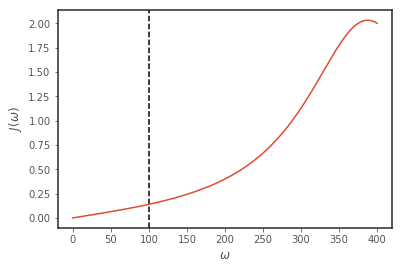

****************************************************************
The operators took 0.37336015701293945 and have dimension 39.
Building the RC Liouvillian took 0.391 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.3229639530181885 seconds.
Full optical Liouvillian took 0.21177196502685547 seconds.
Chopping reduced the sparsity from 2.417% to 2.417%
Liouvillians took 21.413649797439575 seconds
0.9999990133120397 0.9999990177620731 0.999999013312352
5.638428859193045e-07 5.612999141326391e-07 5.638427236018781e-07
0.0 0.0 0.0
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.29s. Est. time left: 00:00:00:00
50.0%. Run time:   0.36s. Est. time left: 00:00:00:00
60.0%. Run time:   0.43s. Est. time left: 00:00:00:00
70.0%. Run time:   0.51s. Est. time left: 00:00:00:00
80.0%. Run time:   0.59s. Est. time left: 00:0

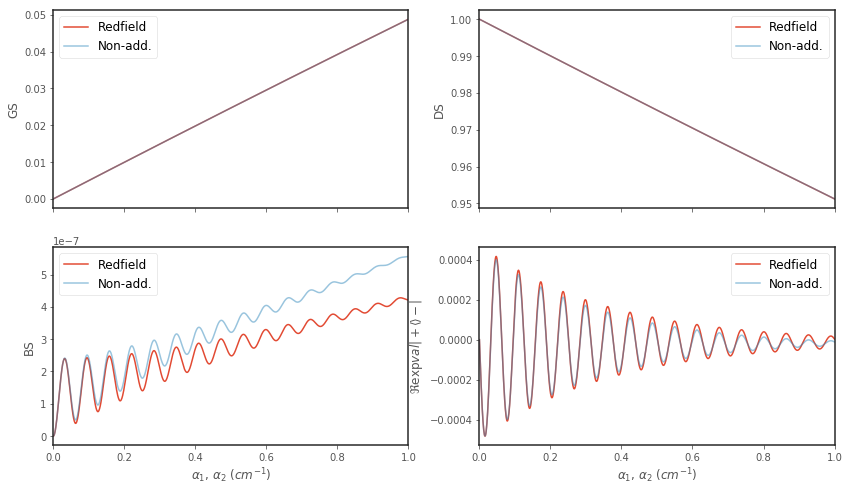

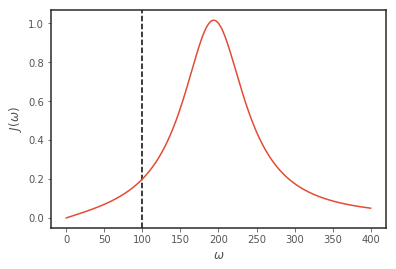

****************************************************************
The operators took 0.45999813079833984 and have dimension 39.
Building the RC Liouvillian took 0.476 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.31314802169799805 seconds.
Full optical Liouvillian took 0.19908785820007324 seconds.
Chopping reduced the sparsity from 2.658% to 2.658%
Liouvillians took 11.374603748321533 seconds
0.9999990133120397 0.999999015539571 0.9999990133123967
5.638428859193045e-07 5.625699631591532e-07 5.638427003480135e-07
0.0 0.0 0.0
10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.0%. Run time:   0.23s. Est. time left: 00:00:00:00
40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.0%. Run time:   0.39s. Est. time left: 00:00:00:00
60.0%. Run time:   0.48s. Est. time left: 00:00:00:00
70.0%. Run time:   0.56s. Est. time left: 00:00:00:00
80.0%. Run time:   0.65s. Est. time left: 00:

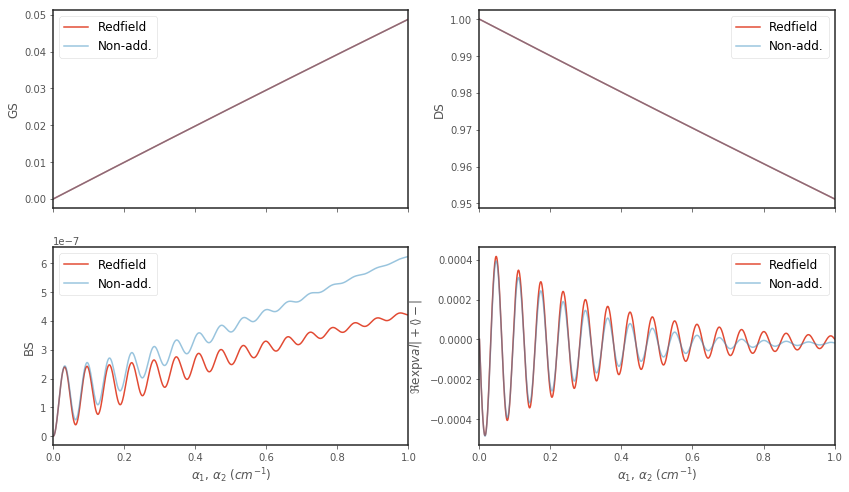

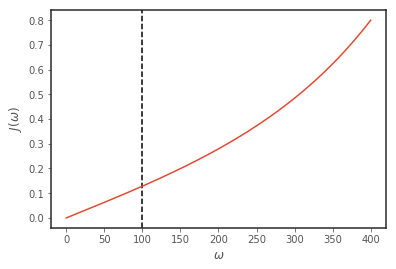

****************************************************************
The operators took 0.3556051254272461 and have dimension 39.
Building the RC Liouvillian took 0.369 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.306412935256958 seconds.
Full optical Liouvillian took 0.20060205459594727 seconds.
Chopping reduced the sparsity from 2.323% to 2.323%
Liouvillians took 45.776219844818115 seconds
0.9999990133120397 0.9999990221920366 0.9999990133122992
5.638428859193045e-07 5.58768411262217e-07 5.638427510440405e-07
0.0 0.0 0.0
10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.36s. Est. time left: 00:00:00:00
40.0%. Run time:   0.48s. Est. time left: 00:00:00:00
50.0%. Run time:   0.61s. Est. time left: 00:00:00:00
60.0%. Run time:   0.73s. Est. time left: 00:00:00:00
70.0%. Run time:   0.85s. Est. time left: 00:00:00:00
80.0%. Run time:   0.97s. Est. time left: 00:00:

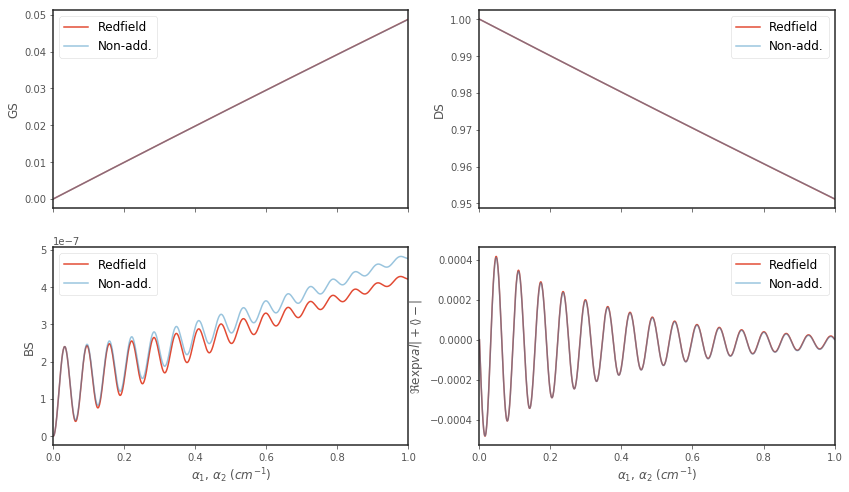

In [29]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 1*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = w_0/2

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

alpha = 0.5
#wc = 50.
w_0 = 200.
Gamma = w_0/2

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

alpha = 2.
#wc = 50.
w_0 = 800.
Gamma = w_0/2.

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

# $J_{max} \approx \eta, V=\epsilon, T_{ph} = T_{EM}$

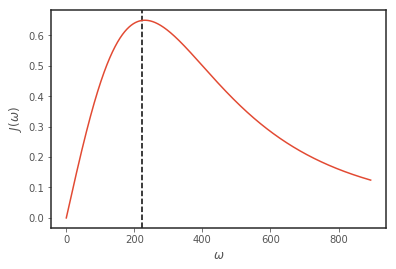

****************************************************************
The operators took 0.8767080307006836 and have dimension 39.
Building the RC Liouvillian took 0.918 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.657120943069458 seconds.
Full optical Liouvillian took 0.22609400749206543 seconds.
Chopping reduced the sparsity from 10.195% to 10.195%
Liouvillians took 13.81730580329895 seconds
0.9999989722644226 0.9999989770074322 0.9999989730632755
6.737959044981797e-07 6.706859365008029e-07 6.729951116993075e-07
-9.149648945639698e-11 -9.107758239249671e-11 -8.395177591723603e-11
10.0%. Run time:   0.70s. Est. time left: 00:00:00:06
20.0%. Run time:   1.47s. Est. time left: 00:00:00:05
30.0%. Run time:   2.12s. Est. time left: 00:00:00:04
40.0%. Run time:   2.77s. Est. time left: 00:00:00:04
50.0%. Run time:   3.46s. Est. time left: 00:00:00:03
60.0%. Run time:   4.19s. Est. time left: 00:00:00:02
70.0%. Run time:   4.92s. Est. time left: 0

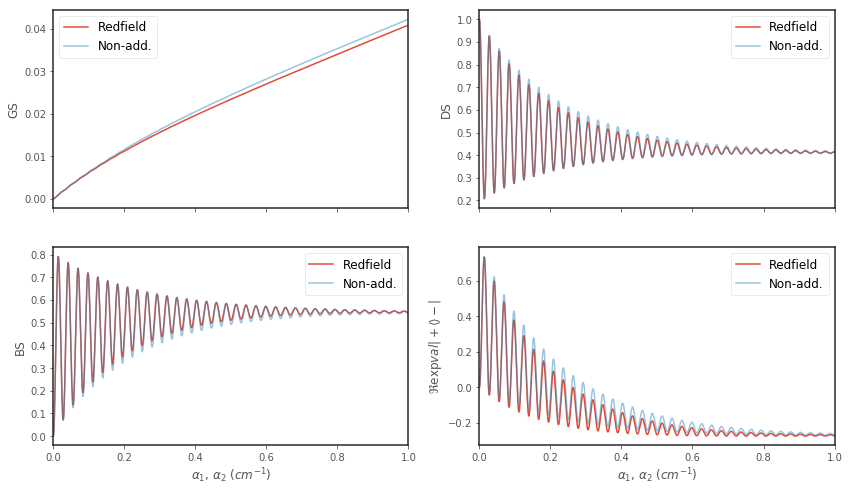

In [6]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 1*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

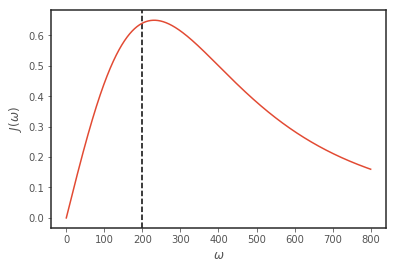

****************************************************************
The operators took 0.7688069343566895 and have dimension 39.
Building the RC Liouvillian took 0.811 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.625532865524292 seconds.
Full optical Liouvillian took 0.2159409523010254 seconds.
Chopping reduced the sparsity from 10.186% to 10.186%
Liouvillians took 20.1958909034729 seconds
0.9999988252986883 0.9999988305966744 0.9999988259914775
7.518563169316319e-07 7.484653917164904e-07 7.511635274483816e-07
-1.996615475355996e-18 1.6893013341802952e-19 -6.307252170716836e-23
10.0%. Run time:   0.63s. Est. time left: 00:00:00:05
20.0%. Run time:   1.25s. Est. time left: 00:00:00:04
30.0%. Run time:   2.02s. Est. time left: 00:00:00:04
40.0%. Run time:   2.79s. Est. time left: 00:00:00:04
50.0%. Run time:   3.57s. Est. time left: 00:00:00:03
60.0%. Run time:   4.34s. Est. time left: 00:00:00:02
70.0%. Run time:   5.10s. Est. time left: 00:

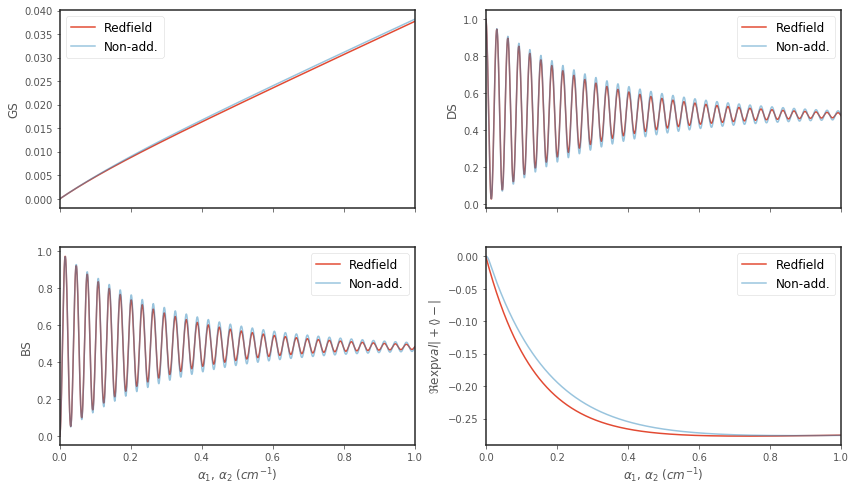

In [7]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 0. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 1*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

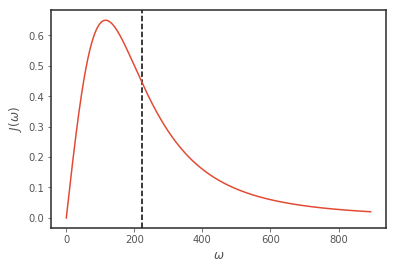

****************************************************************
The operators took 0.7672619819641113 and have dimension 39.
Building the RC Liouvillian took 0.808 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.5955309867858887 seconds.
Full optical Liouvillian took 0.20134806632995605 seconds.
Chopping reduced the sparsity from 10.162% to 10.162%
Liouvillians took 8.048049211502075 seconds
0.9999989719128625 0.9999989766544752 0.999998972980924
6.74165465394167e-07 6.710553942724282e-07 6.730694925780075e-07
-8.808471955690489e-11 -8.769084131018849e-11 -5.7692354569878365e-11
10.0%. Run time:   0.58s. Est. time left: 00:00:00:05
20.0%. Run time:   1.22s. Est. time left: 00:00:00:04
30.0%. Run time:   1.79s. Est. time left: 00:00:00:04
40.0%. Run time:   2.38s. Est. time left: 00:00:00:03
50.0%. Run time:   3.00s. Est. time left: 00:00:00:03
60.0%. Run time:   3.63s. Est. time left: 00:00:00:02
70.0%. Run time:   4.26s. Est. time left: 0

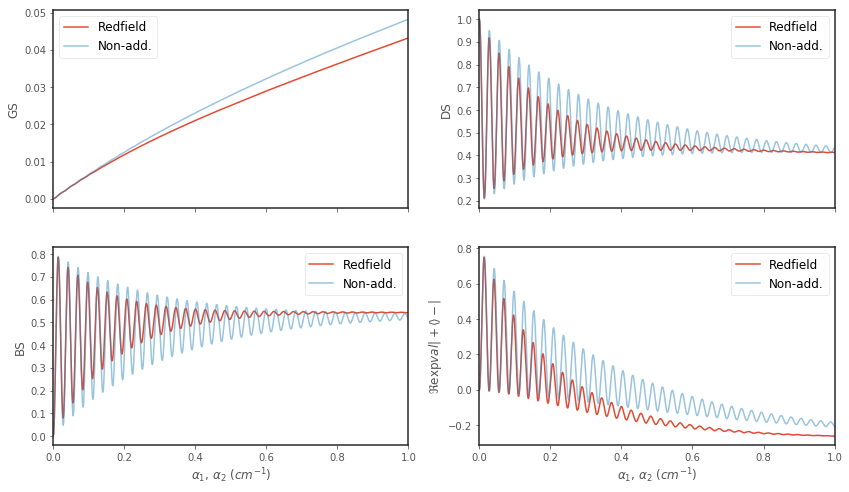

In [8]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 1*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 200.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

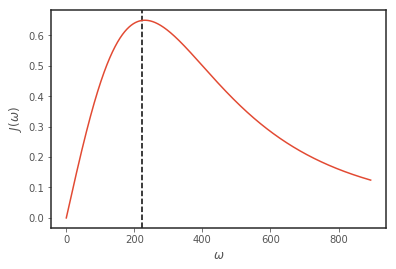

****************************************************************
The operators took 0.7666807174682617 and have dimension 39.
Building the RC Liouvillian took 0.809 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.5937850475311279 seconds.
Full optical Liouvillian took 0.20952177047729492 seconds.
Chopping reduced the sparsity from 10.518% to 10.518%
Liouvillians took 12.865352153778076 seconds
0.874365943277894 0.8745090844246814 0.8744983751911486
0.08235272422463233 0.08224435208128303 0.08221082097954412
-1.1325000502025034e-05 -1.1405585197535317e-05 -1.0515510560501703e-05
10.0%. Run time:   0.64s. Est. time left: 00:00:00:05
20.0%. Run time:   1.29s. Est. time left: 00:00:00:05
30.0%. Run time:   1.89s. Est. time left: 00:00:00:04
40.0%. Run time:   2.55s. Est. time left: 00:00:00:03
50.0%. Run time:   3.24s. Est. time left: 00:00:00:03
60.0%. Run time:   3.93s. Est. time left: 00:00:00:02
70.0%. Run time:   4.63s. Est. time left: 00:

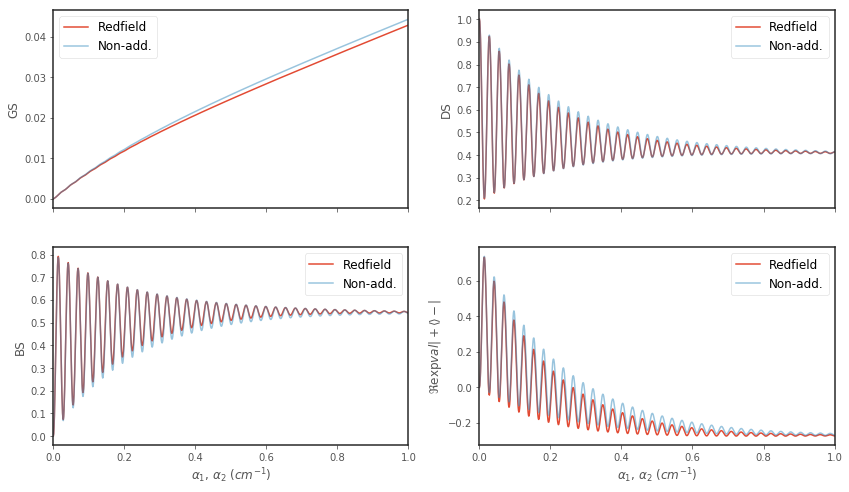

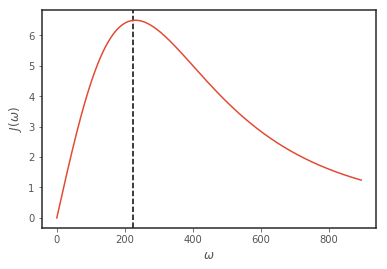

****************************************************************
The operators took 1.6132080554962158 and have dimension 57.
Building the RC Liouvillian took 1.755 seconds.
It is 3249by3249. The full basis would be 5625by5625
Full optical Liouvillian took 1.182715892791748 seconds.
Full optical Liouvillian took 0.4106619358062744 seconds.
Chopping reduced the sparsity from 7.561% to 7.561%
Liouvillians took 25.644689083099365 seconds
0.8741934632325842 0.8752795308944059 0.8749394056158986
0.082543921664941 0.0818295849066607 0.08176704837346052
-8.93602336796695e-05 -8.828986938024322e-05 -0.00010733850551189097
10.0%. Run time:   1.69s. Est. time left: 00:00:00:15
20.0%. Run time:   3.53s. Est. time left: 00:00:00:14
30.0%. Run time:   5.39s. Est. time left: 00:00:00:12
40.0%. Run time:   7.71s. Est. time left: 00:00:00:11
50.0%. Run time:   9.65s. Est. time left: 00:00:00:09
60.0%. Run time:  11.55s. Est. time left: 00:00:00:07
70.0%. Run time:  13.45s. Est. time left: 00:00:00:05


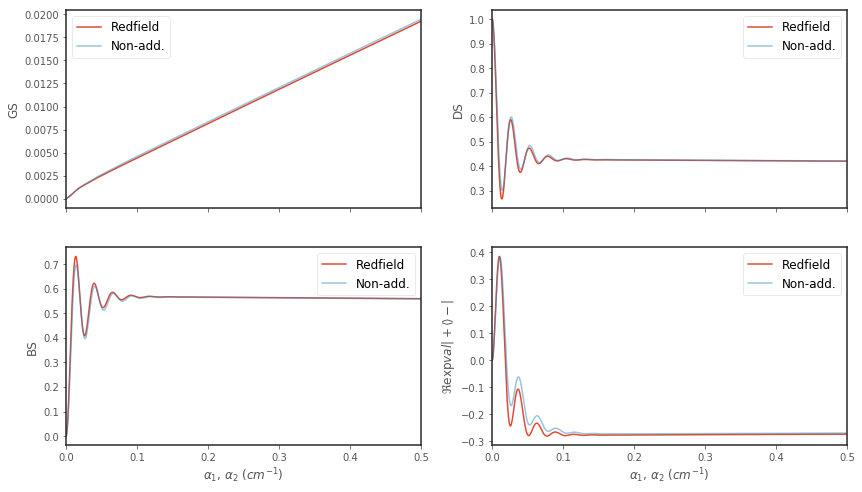

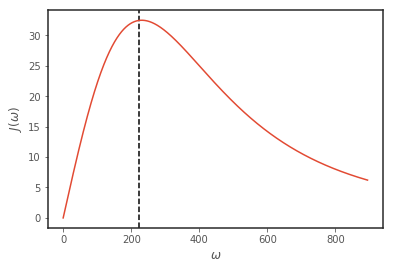

****************************************************************
The operators took 1.5914502143859863 and have dimension 57.
Building the RC Liouvillian took 1.720 seconds.
It is 3249by3249. The full basis would be 5625by5625
Full optical Liouvillian took 1.2482168674468994 seconds.
Full optical Liouvillian took 0.41640186309814453 seconds.
Chopping reduced the sparsity from 7.860% to 7.860%
Liouvillians took 40.70861887931824 seconds
0.8739226543366925 0.8790565635820419 0.8770292364634079
0.08284411852315891 0.07946950962620554 0.07963498714554035
-0.000235252642960454 -0.00022463994407760646 -0.0005033947988341177
10.0%. Run time:   1.77s. Est. time left: 00:00:00:15
20.0%. Run time:   3.90s. Est. time left: 00:00:00:15
30.0%. Run time:   5.88s. Est. time left: 00:00:00:13
40.0%. Run time:   7.87s. Est. time left: 00:00:00:11
50.0%. Run time:   9.87s. Est. time left: 00:00:00:09
60.0%. Run time:  11.89s. Est. time left: 00:00:00:07
70.0%. Run time:  13.83s. Est. time left: 00:00:00

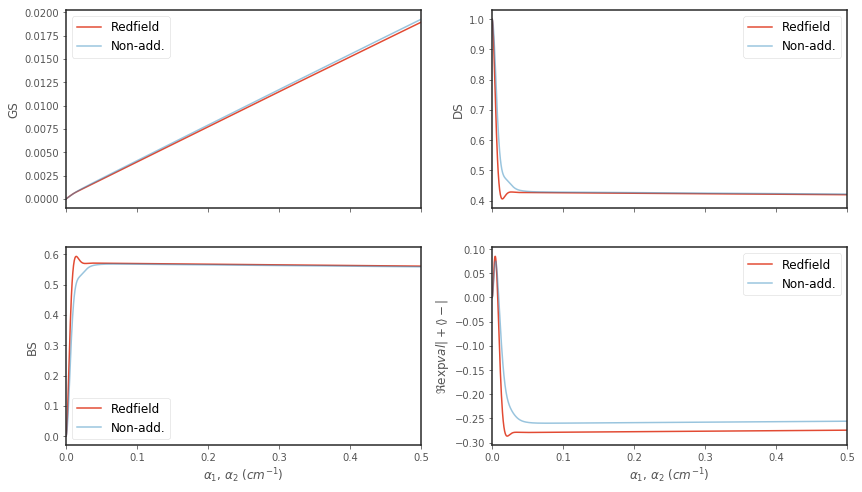

In [10]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 5*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

alpha = 10.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0
N=5
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=0.5, shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

alpha = 50.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=0.5, shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

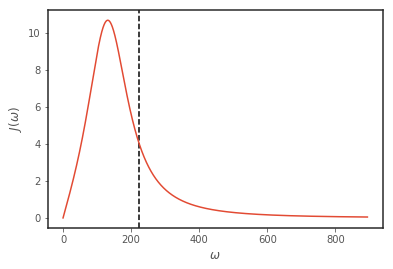

****************************************************************
The operators took 1.6155071258544922 and have dimension 57.
Building the RC Liouvillian took 1.733 seconds.
It is 3249by3249. The full basis would be 5625by5625
Full optical Liouvillian took 1.1829111576080322 seconds.
Full optical Liouvillian took 0.41814303398132324 seconds.
Chopping reduced the sparsity from 7.407% to 7.407%
Liouvillians took 10.384566068649292 seconds
0.15125550595779697 0.1652215612998783 0.20971120305515223
0.8446613718360909 0.8304923409053887 0.7693888383371041
-0.01041210527547512 -0.01024921791708211 -0.010701348793027485
10.0%. Run time:   0.53s. Est. time left: 00:00:00:04
20.0%. Run time:   0.92s. Est. time left: 00:00:00:03
30.0%. Run time:   1.35s. Est. time left: 00:00:00:03
40.0%. Run time:   1.77s. Est. time left: 00:00:00:02
50.0%. Run time:   2.07s. Est. time left: 00:00:00:02
60.0%. Run time:   2.37s. Est. time left: 00:00:00:01
70.0%. Run time:   2.66s. Est. time left: 00:00:00:01
8

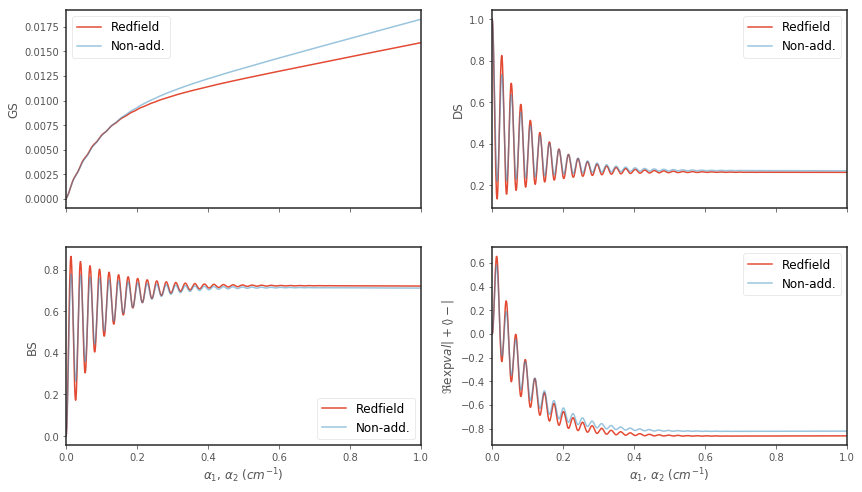

In [26]:
T_ph = 77.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 6000.
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5

alpha = 10.
#wc = 50.
w_0 = 150.
Gamma = 1*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
plot_UD_SD(Gamma, alpha, w_0, eps=4*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, 'O', threshold=0., tf=1., shift_in_WC=True, shift_in_WC_Liouv=True)
plot_dynamics(dynamics_1a)

Low frequency really doesn't work. The best agreement is high frequency, broadly damped modes.
This seems to even work fairly well at stronger couplings (short term dynamics). Now we will check the steadystates as this seems to be where the most confusing results are.

In [18]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 5*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0


data_dict_1 = calculate_WC_add_steadystate_comparison(PARAMS, 1, threshold=0., 
                                                      shift_in_WC=True, shift_in_WC_Liouv=True)


1.1724137931034484
7.224137931034483
13.948275862068966
Calculation took 436.64158177375793 seconds
Filename: DATA/WC_validity_ss/3ls_1


(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


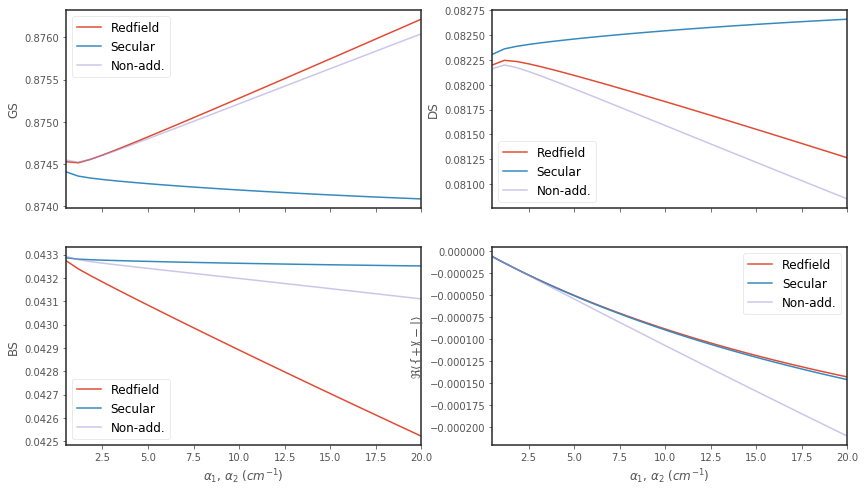

In [19]:
plot_steadystates(data_dict_1)

1.1724137931034484
7.224137931034483
13.948275862068966
Calculation took 433.9485650062561 seconds
Filename: DATA/WC_validity_ss/3ls_1
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


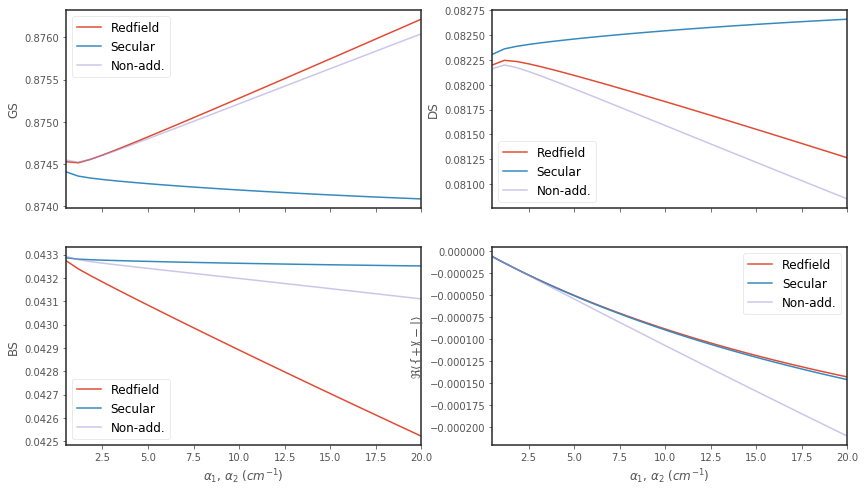

In [20]:
T_ph = 500.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 5*T_ph
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5

alpha = 1.
#wc = 50.
w_0 = 200.
Gamma = 2*w_0


data_dict_2 = calculate_WC_add_steadystate_comparison(PARAMS, 1, threshold=0., 
                                                      shift_in_WC=True, shift_in_WC_Liouv=True)
plot_steadystates(data_dict_2)

1.1724137931034484
7.224137931034483
13.948275862068966
Calculation took 435.2703731060028 seconds
Filename: DATA/WC_validity_ss/3ls_1
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(3, 3) (3, 3) (3, 3) (3, 3)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)
(57, 57) (57, 57) (57, 57) (57, 57)


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


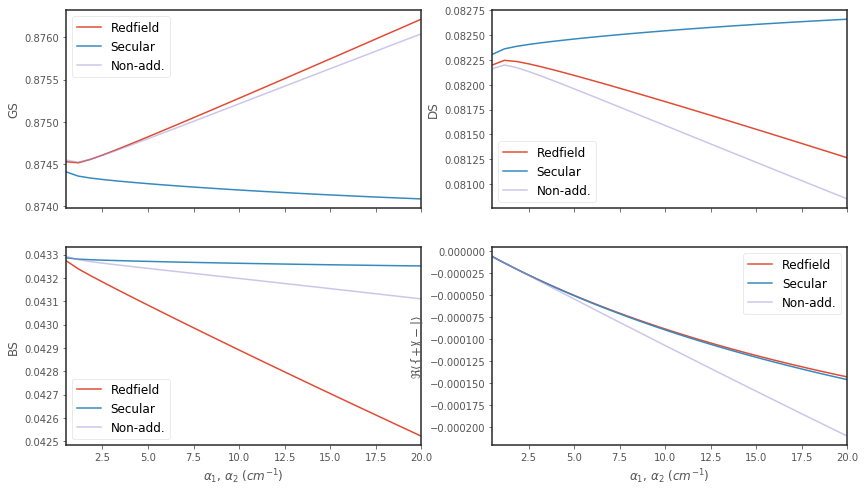

In [21]:
T_ph = 77.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
eta = sqrt(bias**2 + 4*V**2)
T_EM = 2500.
alpha_EM = 0.05 #0.05 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5

alpha = 1.
#wc = 50.
w_0 = 400.
Gamma = 2*w_0


data_dict_3 = calculate_WC_add_steadystate_comparison(PARAMS, 1, threshold=0., 
                                                      shift_in_WC=True, shift_in_WC_Liouv=True)
plot_steadystates(data_dict_3)

In [26]:
dynamics_1a = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1a")
dynamics_1b = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1b")
dynamics_1c = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1c")

# larger $\omega_0$

In [18]:
w_0 = 500.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2a = get_dynamics_data(PARAMS, '2a', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2b = get_dynamics_data(PARAMS, '2b', threshold=0., tf=1)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2c = get_dynamics_data(PARAMS, '2c', threshold=0., tf=0.25)

****************************************************************
The operators took 2.126779794692993 and have dimension 57.
Building the RC Liouvillian took 2.300 seconds.
It is 3249by3249. The full basis would be 5625by5625
Not including optical dissipator
Chopping reduced the sparsity from 5.999% to 5.999%
Liouvillians took 3.3814499378204346 seconds
1.0 1.0 1.0015154890860969 1.0015154890860969
0.0 0.0 3.3495089358429103e-07 3.3495089358429103e-07
10.0%. Run time:   2.85s. Est. time left: 00:00:00:25
20.0%. Run time:   5.28s. Est. time left: 00:00:00:21
30.0%. Run time:   7.88s. Est. time left: 00:00:00:18
40.0%. Run time:  10.79s. Est. time left: 00:00:00:16
50.0%. Run time:  13.20s. Est. time left: 00:00:00:13
60.0%. Run time:  15.83s. Est. time left: 00:00:00:10
70.0%. Run time:  18.64s. Est. time left: 00:00:00:07
80.0%. Run time:  21.21s. Est. time left: 00:00:00:05
90.0%. Run time:  23.77s. Est. time left: 00:00:00:02
Total run time:  26.38s
10.0%. Run time:   2.49s. Est. tim

In [28]:
dynamics_2a = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2a")
dynamics_2b = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2b")
dynamics_2c = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2c")

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


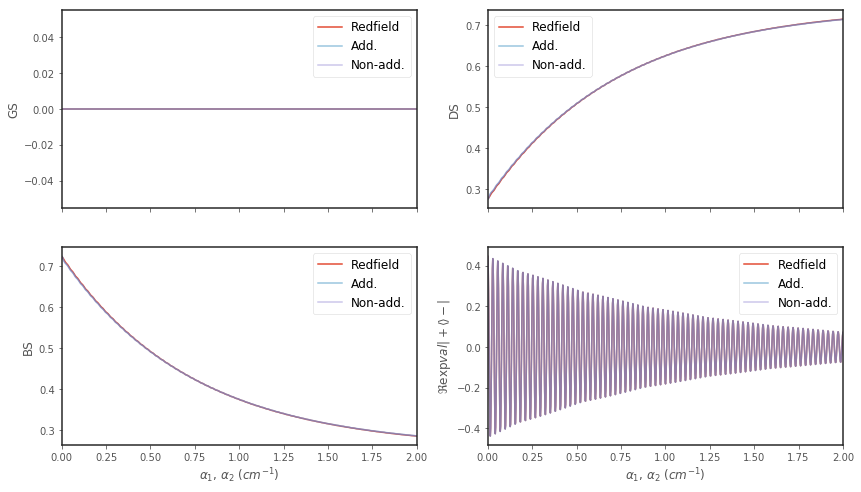

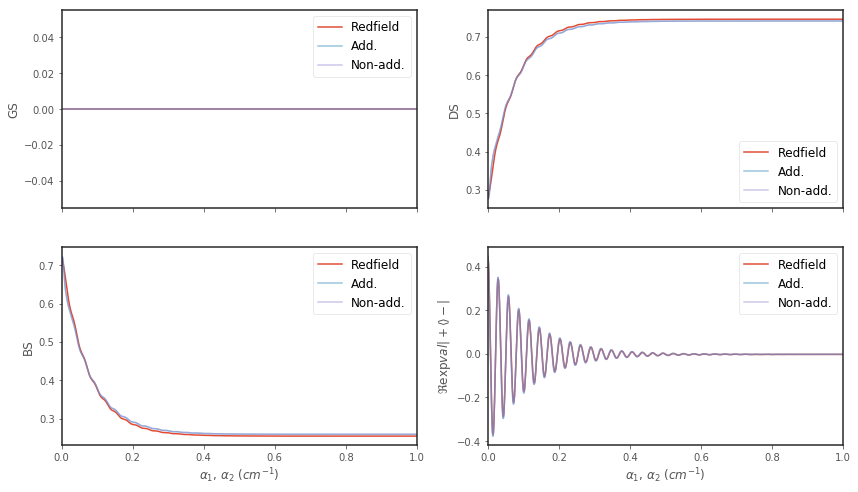

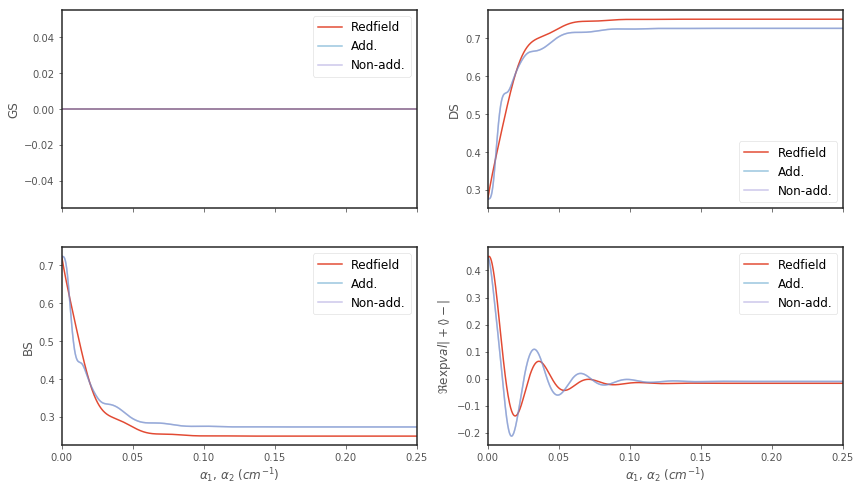

In [29]:
plot_dynamics(dynamics_2a)
plot_dynamics(dynamics_2b)
plot_dynamics(dynamics_2c)

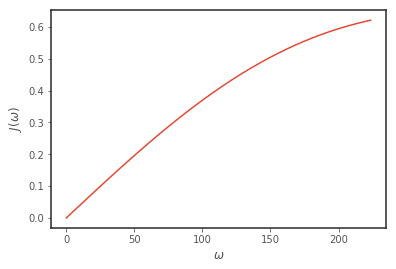

In [44]:
plot_UD_SD(Gamma, alpha, 500., eps=1*sqrt(bias**2 +4*(V**2)), ax=None)

# Low $T_{ph}$

In [15]:
w_0 = 200.
Gamma = 200.
N=5
T_ph = 77.
alpha_EM = 0. #0.01
T_EM=6000.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3aa = get_dynamics_data(PARAMS, '3aa', threshold=0., tf=3)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3bb = get_dynamics_data(PARAMS, '3bb', threshold=0., tf=2)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3cc = get_dynamics_data(PARAMS, '3cc', threshold=0., tf=2)

****************************************************************
The operators took 0.8845999240875244 and have dimension 57.
Building the RC Liouvillian took 0.938 seconds.
It is 3249by3249. The full basis would be 5625by5625
Not including optical dissipator
Chopping reduced the sparsity from 1.857% to 1.857%
Liouvillians took 2.2360448837280273 seconds
1.0 1.0 1.0000000000000002 1.0000000000000002
0.0 0.0 0.0 0.0
10.0%. Run time:   0.61s. Est. time left: 00:00:00:05
20.0%. Run time:   1.25s. Est. time left: 00:00:00:05
30.0%. Run time:   1.87s. Est. time left: 00:00:00:04
40.0%. Run time:   2.48s. Est. time left: 00:00:00:03
50.0%. Run time:   3.09s. Est. time left: 00:00:00:03
60.0%. Run time:   3.69s. Est. time left: 00:00:00:02
70.0%. Run time:   4.29s. Est. time left: 00:00:00:01
80.0%. Run time:   4.89s. Est. time left: 00:00:00:01
90.0%. Run time:   5.50s. Est. time left: 00:00:00:00
Total run time:   6.10s
10.0%. Run time:   0.60s. Est. time left: 00:00:00:05
20.0%. Run time: 

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


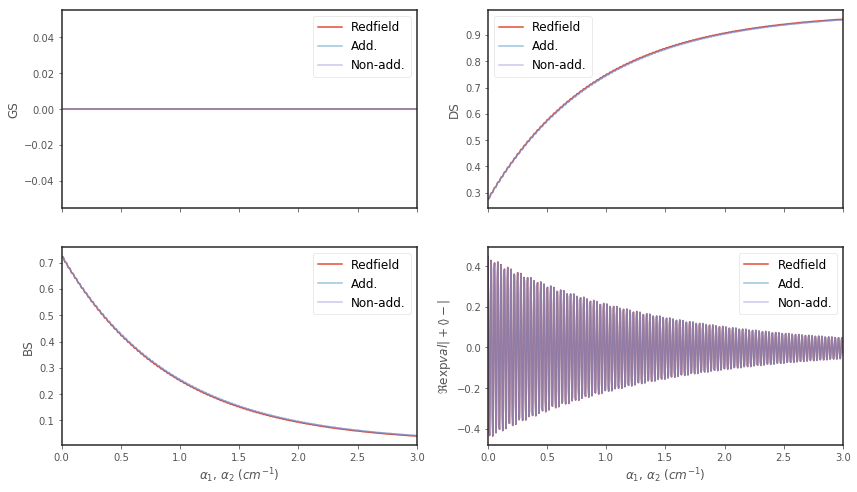

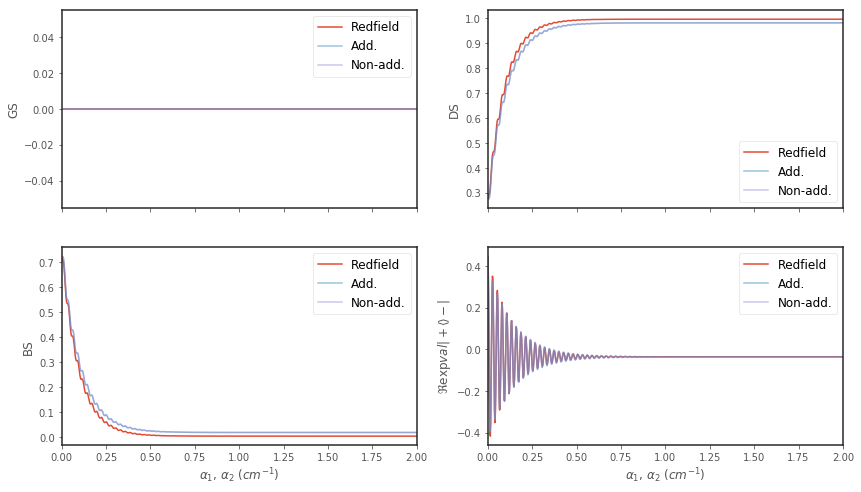

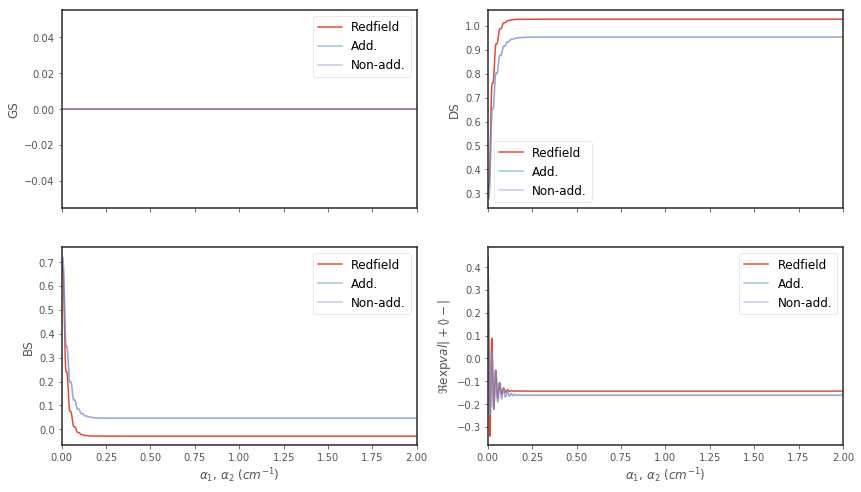

In [16]:
plot_dynamics(dynamics_3aa)
plot_dynamics(dynamics_3bb)
plot_dynamics(dynamics_3cc)

# very high $\omega_0$ (underdamped), but not larger than site energy

In [19]:
w_0 = 5000.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4a = get_dynamics_data(PARAMS, '4a', threshold=1e-9, tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4b = get_dynamics_data(PARAMS, '4b', threshold=1e-9, tf=1)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4c = get_dynamics_data(PARAMS, '4c', threshold=1e-9, tf=0.25)

****************************************************************
The operators took 2.0762829780578613 and have dimension 57.
Building the RC Liouvillian took 2.246 seconds.
It is 3249by3249. The full basis would be 5625by5625
Not including optical dissipator
Chopping reduced the sparsity from 5.984% to 4.904%
Liouvillians took 4.9206390380859375 seconds
1.0 1.0 1.0000000007175742 1.0000000007175742
0.0 0.0 2.0113592011533587e-14 2.0113592011533587e-14
10.0%. Run time:  19.82s. Est. time left: 00:00:02:58
20.0%. Run time:  39.99s. Est. time left: 00:00:02:39
30.0%. Run time:  60.51s. Est. time left: 00:00:02:21
40.0%. Run time:  80.78s. Est. time left: 00:00:02:01
50.0%. Run time: 100.71s. Est. time left: 00:00:01:40
60.0%. Run time: 121.08s. Est. time left: 00:00:01:20
70.0%. Run time: 141.20s. Est. time left: 00:00:01:00
80.0%. Run time: 160.80s. Est. time left: 00:00:00:40
90.0%. Run time: 180.94s. Est. time left: 00:00:00:20
Total run time: 200.75s
10.0%. Run time:  19.79s. Est. ti

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


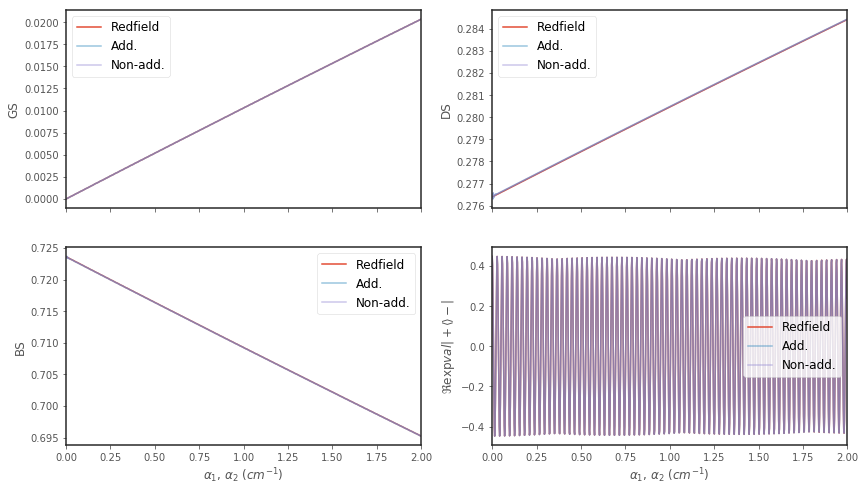

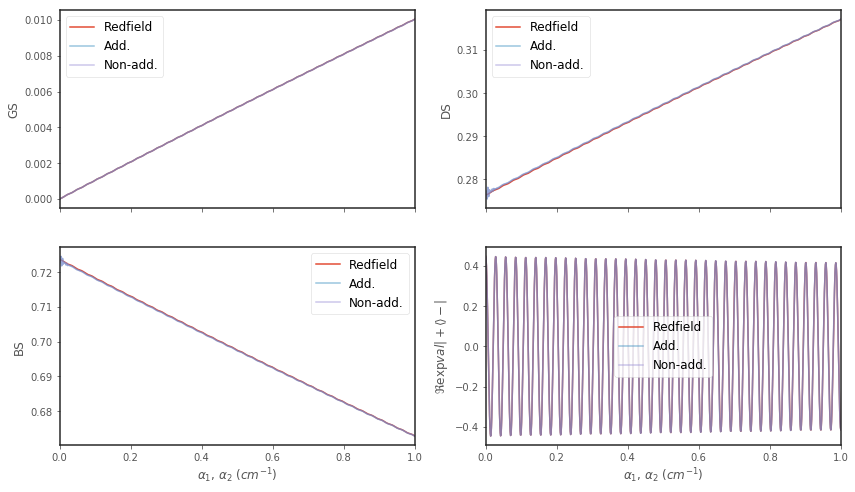

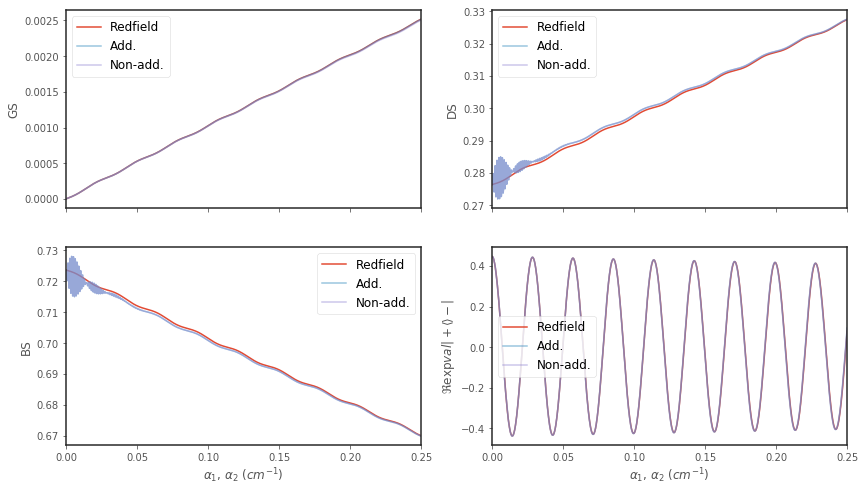

In [59]:
plot_dynamics(dynamics_4a)
plot_dynamics(dynamics_4b)
plot_dynamics(dynamics_4c)

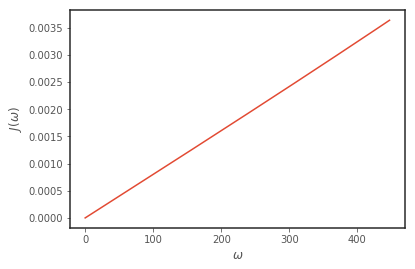

In [22]:
plot_UD_SD(200., 1., 5000., eps=2*sqrt(bias**2 +4*(V**2)), ax=None)

# very high $\omega_0$ (overdamped), but not larger than site energy

In [33]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
N=3
T_ph = 300.
alpha_EM = 0.001
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5a = get_dynamics_data(PARAMS, '5a', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5b = get_dynamics_data(PARAMS, '5b', threshold=0., tf=1)


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5c = get_dynamics_data(PARAMS, '5c', threshold=0., tf=1.)

****************************************************************
The operators took 0.3537909984588623 and have dimension 24.
Building the RC Liouvillian took 0.369 seconds.
It is 576by576. The full basis would be 729by729
It took  0.354508638381958  seconds to build the Non-secular RWA Liouvillian
It took  0.14738702774047852  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 14.354% to 14.354%
Liouvillians took 15.04849886894226 seconds
0.48748875351722604 0.4875905277059754 0.4892247447966356 0.4892125689120085
-0.0001090445252694 -0.00010913569965179115 -6.16720317691382e-05 -6.167210442677128e-05
10.0%. Run time:  10.31s. Est. time left: 00:00:01:32
20.0%. Run time:  21.83s. Est. time left: 00:00:01:27
30.0%. Run time:  33.49s. Est. time left: 00:00:01:18
40.0%. Run time:  43.97s. Est. time left: 00:00:01:05
50.0%. Run time:  54.22s. Est. time left: 00:00:00:54
60.0%. Run time:  64.44s. Est. time left: 00:00:00:42
70.0%. Run time:  74.77s. Est. ti

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


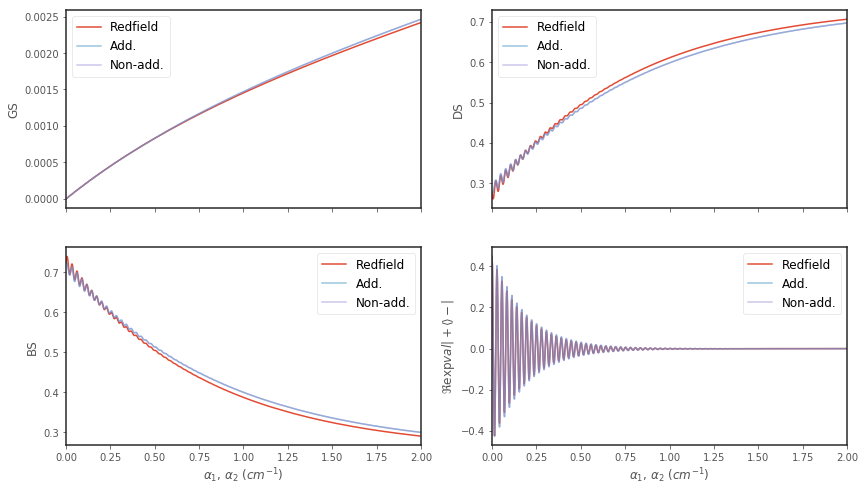

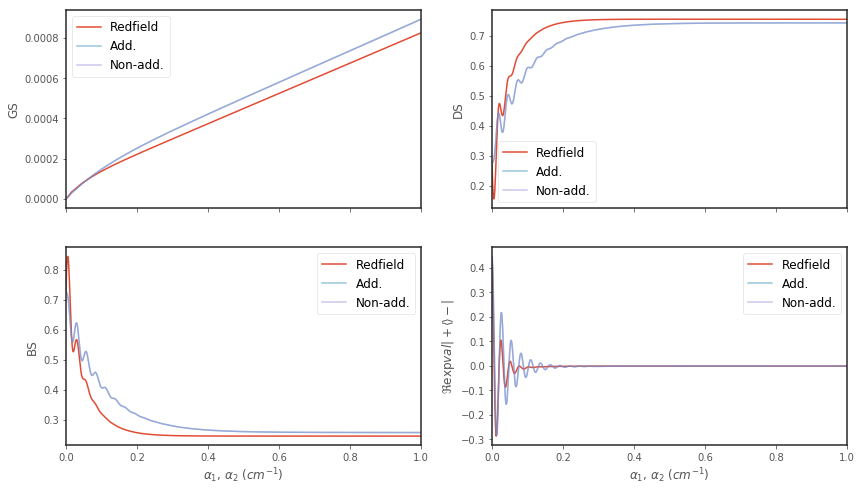

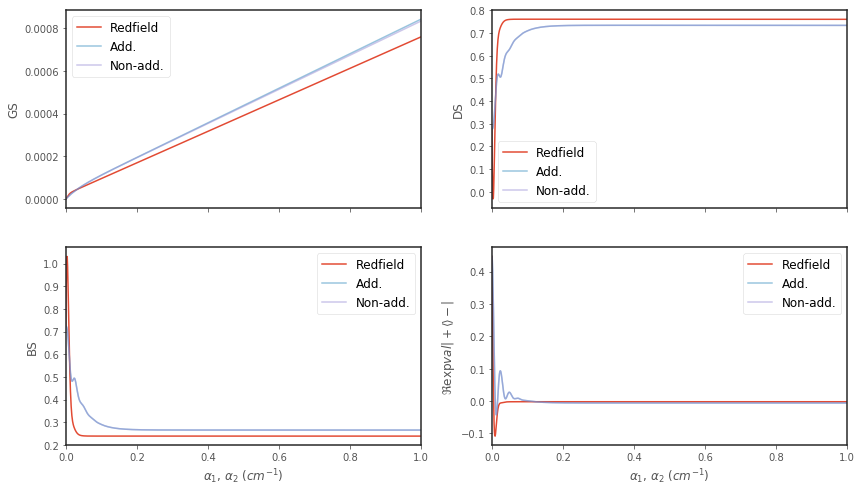

In [35]:
plot_dynamics(dynamics_5a)
plot_dynamics(dynamics_5b)
plot_dynamics(dynamics_5c)

In [ ]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
N=4
T_ph = 300.
"""PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5aa = get_dynamics_data(PARAMS, '5aa', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5bb = get_dynamics_data(PARAMS, '5bb', threshold=1e-8, tf=1)
"""
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5cc = get_dynamics_data(PARAMS, '5cc', threshold=1e-8, tf=0.25)

In [10]:
dynamics_5aa = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5aa")
dynamics_5bb = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5bb")
dynamics_5cc = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5cc")

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


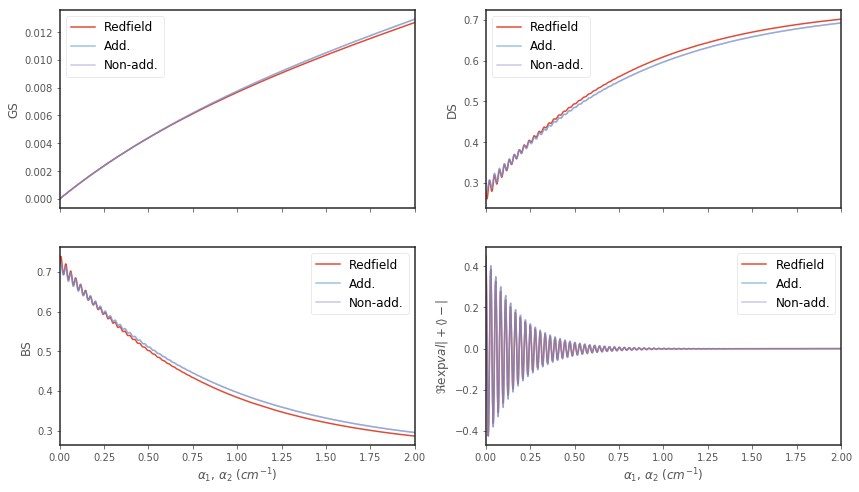

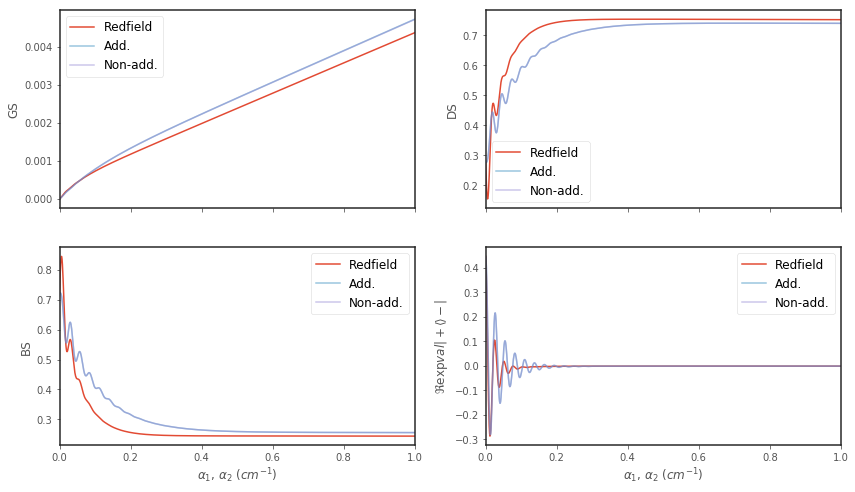

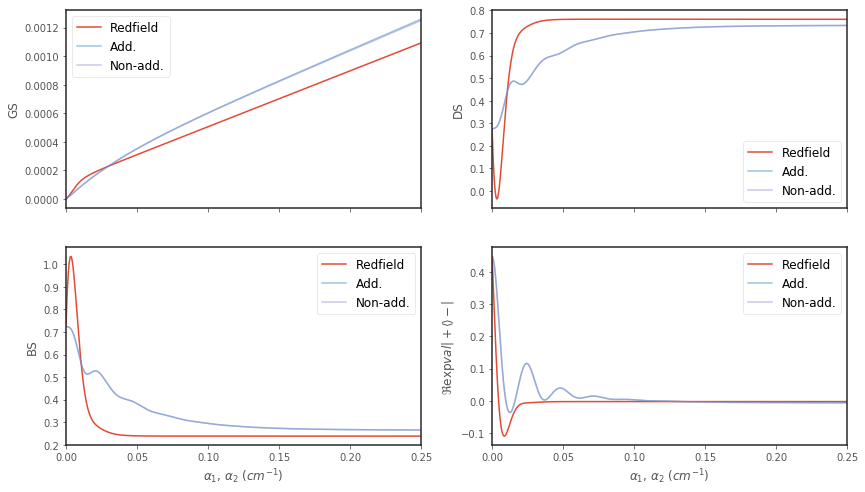

In [11]:
plot_dynamics(dynamics_5aa)
plot_dynamics(dynamics_5bb)
plot_dynamics(dynamics_5cc)

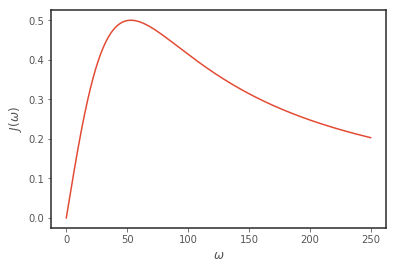

In [24]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
alpha=1.
plot_UD_SD(Gamma, alpha, w_0, eps=250., ax=None)